## Final Project Submission

by Markus


In [211]:
# Your code here - remember to use markdown cells for comments as well!

In [212]:
reset -fs

In [213]:
#importing the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

%matplotlib inline


In [214]:
df = pd.read_csv('King_County_House_prices_dataset.csv')

**(optional)** Anzeigen von allen Werte, die nicht numerisch sind. 

In [215]:
#df.applymap(np.isreal)

## Cleaning and specification

In [216]:
#Drop view, sqft_lot15
del df['view']
#del df['sqft_lot15']

#Überschreiben der NaN in Spalte 'waterfront'
df['waterfront'].fillna(value = 0, inplace=True)

#Überschreiben der Fragezeichen "?"
df['sqft_basement'] = df['sqft_basement'].str.replace('?','0')
df['sqft_basement'] = df['sqft_basement'].astype(float).astype(int)

#Boolean for renovated (0 = False, 1 = True)
df['was_renovated'] = df['yr_renovated']
df.loc[df.was_renovated > 0, 'was_renovated'] = 1
df.loc[df.was_renovated != 1, 'was_renovated'] = 0
df['was_renovated'] = df['was_renovated'].astype(float).astype(int)
#df['was_renovated'].value_counts()

#Replaces NaN and empty cells with yr_built

df['renovated'] = df['yr_renovated']
df.loc[df.renovated > 0, 'renovated'] = df.renovated
df.loc[df.renovated != 1, 'renovated'] = df.yr_built
df['renovated'] = df['renovated'].astype(float).astype(int)

#Überschreiben der NaN-Werte in yr_renovated mit 0
#Und passe entsprechend renovated an
df['yr_renovated'] = df.yr_renovated.replace(np.NaN, '0')
df['yr_renovated'] = df['yr_renovated'].astype(float).astype(int)

#Split date by day, month and year
df[['day','month', 'year']] = df['date'].str.split('/',expand=True)

#Define Feature age
df['age'] = (2020 - (df['yr_built'].astype(int)))


(optional) Anzeigen aller Rows mit "?". Es sollten keine Rows mehr auftauchen.

In [217]:
#df[df["sqft_basement"].str.contains('\?', na=False)]

## Add features

In [218]:
#Dependent on price
df['living_price_sqft'] = df['price'] / df['sqft_living']
df['lot_price_sqft'] = df['price'] / df['sqft_lot']

#Not depending on price
df['bath_bed_ratio'] = df['bathrooms'] / df['bedrooms']
df['sqft_prod'] = (df['sqft_living'] * df['sqft_living15'])**(1/2)

In [219]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

#Coordinates of main Google Office in Seattle
google_lat = 47.649210
google_long = -122.350370
google_lat_long = (47.649210, -122.350370)

def haversine(long, lat):
    lon1 = -122.350370
    lat1 = 47.649210
    lon2 = long
    lat2 = lat
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

df['distance'] = df.apply(lambda row: haversine(row['long'], row['lat']), axis=1)
#df[['price', 'long', 'lat', 'distance']]
#df.sort_values(by='distance', ascending=False)

### Simple approach to calculate classes "Grading" for neighborhoods (classes from 1 to 5 - cheap to expensive)

In [220]:
conditions = [
    (df['price'] > 1000000),
    (df['price'] > 800000),
    (df['price'] > 600000),
    (df['price'] > 200000),
    (df['price'] > 0)]
choices = ['5', '4', '3', '2', '1']
df['zip_price_class'] = np.select(conditions, choices, default='9000')
#df.head(20)
#temp_df['zip_price_class'].unique()


In [221]:
#Creation of a subset with criteria of customer requirements

fam_distance_max =  20
fam_monthly_mortgage = 4000 #per month
fam_bedrooms = 3 #min()
fam_bathrooms = 2 #min()

subset_family = df[(df.bathrooms >= fam_bathrooms) 
                   & (df.bedrooms >= fam_bathrooms) 
                   & (df.price <= (20 * 12 * fam_monthly_mortgage))
                   & (df.distance <= fam_distance_max)]
subset_family.head()
subset_family.price.mean()

572689.1296638345

In [222]:
#Remove all Outliers (cell-wise) per Column. Deletion of rows afterwards (dropna)

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.05)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(subset_family)
#print(nonOutlierList)

# Non-Outlier Subset of the Given Dataset
subset_family = subset_family[nonOutlierList]

#Drop NA in df dataframe
subset_family = subset_family.dropna()

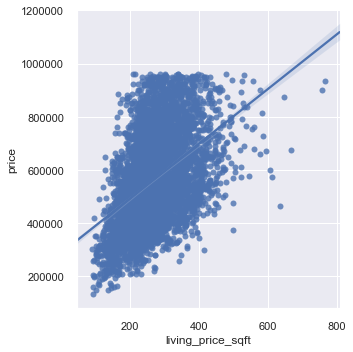

In [223]:
sns.lmplot(x="living_price_sqft", y="price", data=subset_family)

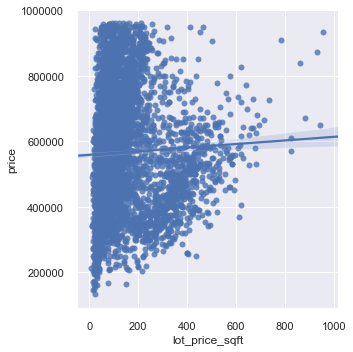

In [224]:
sns.lmplot(x="lot_price_sqft", y="price", data=subset_family)

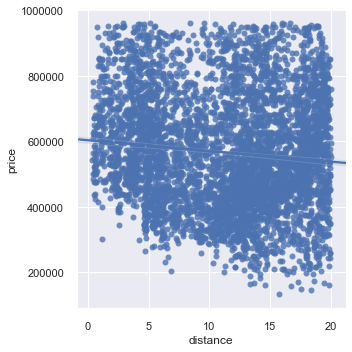

In [225]:
sns.lmplot(x="distance", y="price", data=subset_family)

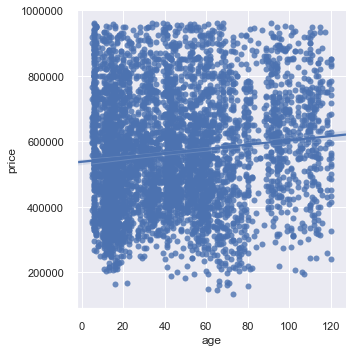

In [226]:
sns.lmplot(x="age", y="price", data=subset_family)
#subset_family.age

In [227]:
#sns.lmplot(x="zip_price_class", y="price", data=df)

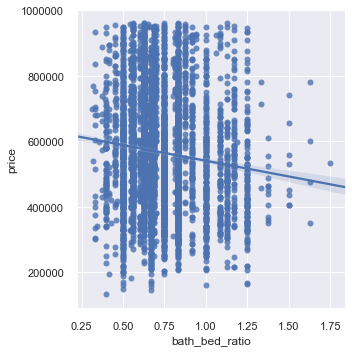

In [228]:
sns.lmplot(x="bath_bed_ratio", y="price", data=subset_family)

In [229]:
#Validation of data quality / isnull and isna
#df.isnull().sum(), df.isna().sum()

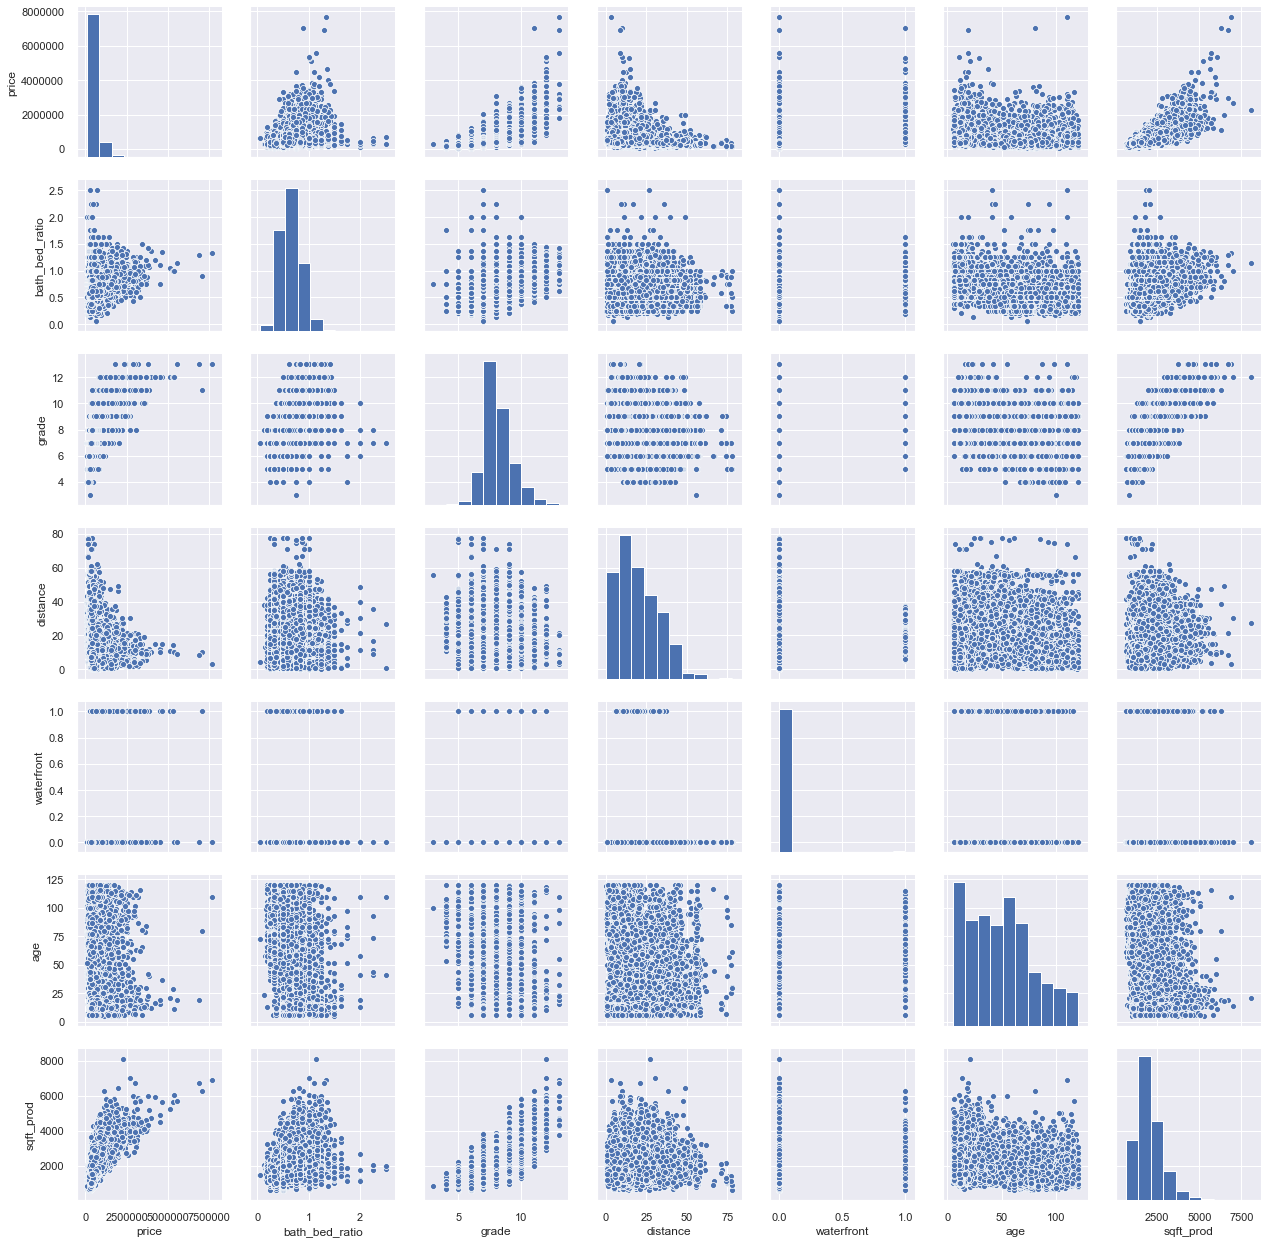

In [230]:
sns.set()
cols = ['price', 'bath_bed_ratio', 'grade', 'distance', 'waterfront', 'age', 'sqft_prod']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [231]:
train_df, test_df = train_test_split(subset_family, test_size=0.2)

In [232]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(train_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [ ]:
profile.to_widgets()

In [ ]:
#zip_view = df.groupby(df['zipcode']).count()
#zip_view = pd.cut(df['zipcode'], bins=np.arange(98000, 98220, 20))
#zip_view
sns.distplot(train_df['zipcode'], kde=False, rug=True);

In [ ]:
#temp = train_df[['price', 'bedrooms', 'sqft_living', 'condition', 'grade', 'zipcode']]
#sns.pairplot(temp);

In [ ]:
subset_family.columns.values

In [ ]:
#type(df['sqft_basement'])
#df['sqft_basement'].head(50)
#df['sqft_basement'].astype('int32').dtypes
#pd.Series(df['sqft_basement']).str.replace(',', '').astype(int)

#temp['sqft_basement']

#df["sqft_basement"][400:500]


In [ ]:
#df['sqft_basement'][100:200].
#df.applymap(np.isreal).all(1)
#np.argmin(df.applymap(np.isreal).all(1))
#Binäre Darstellung, invertiert die "Echtheit" auf Numerischen Value prüft
#df[~df.applymap(np.isreal).all(1)]

In [ ]:
#Plot von 'bedrooms' in subset_family  
var = 'bedrooms'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=3500000);
fig.axis(ymin=0, ymax=1000000);

In [ ]:
#Plot von 'grade' in subset_family  
var = 'grade'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=3500000);
fig.axis(ymin=0);

In [ ]:
#Plot von 'grade' in subset_family  
var = 'condition'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=3500000);
fig.axis(ymin=0);

In [ ]:
#Plot von 'yr_built' in subset_family  
var = 'yr_built'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 14))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=300000, ymax=800000);
plt.xticks(rotation=90);

In [ ]:
df.was_renovated.unique()

In [ ]:
# Set theme
#sns.set_style('whitegrid')
 
# Violin plot
#fig = sns.violinplot(x='grade', y='price', hue='was_renovated', data=train_df, split=True, scale="count")
#fig.axis(ymax=2000000);

In [ ]:
model1 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + sqft_above + sqft_living + sqft_living15 + sqft_basement', data=train_df).fit().summary()
#model1 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + view + sqft_above + sqft_living + sqft_living15', data=df).fit().summary()
#df.columns.values

model2 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + sqft_above + sqft_living + sqft_basement', data=train_df).fit().summary()
model3 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + sqft_living +  sqft_basement', data=train_df).fit().summary()
model4 = smf.ols(formula='price ~ bath_bed_ratio + grade + distance + sqft_living + waterfront + renovated + age', data=train_df).fit().summary()

model4

In [ ]:
model5 = smf.ols(formula='price ~ bath_bed_ratio', data=train_df).fit().summary()
model5

sns.lmplot(x='bedrooms', y='price', data=train_df)

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sms

%matplotlib inline

In [ ]:
subset_family.columns.values

In [ ]:
#price ~ bath_bed_ratio + grade + distance + sqft_living + waterfront + renovated + age
#constants = ['bath_bed_ratio', 'grade', 'distance', 'sqft_living', 'waterfront', 'age', 'living_price_sqft']
constants = ['bath_bed_ratio', 'grade', 'distance', 'waterfront', 'age', 'sqft_prod']
X = train_df[constants]
X = sms.add_constant(X)
y = train_df.price

#model16 = smf.ols(formula='price ~ sqft_living', data=subset_family).fit().summary()

model = sms.OLS(y, X).fit()
model.summary()

In [ ]:
pred_price = -313500 
            - (bbr * 22660) 
            + (grade * 76960) 
            - (dist * 11140) 
            - (water * 0.000000000919) 
            + (age * 1170) 
            + (sqft + 183)

In [ ]:
#price ~ bedrooms + grade + lat + view + sqft_living
X_test = test_df[constants]
X_test = sms.add_constant(X_test)
y_test = test_df.price

#y_test.hist()

In [ ]:
pred_prices = model.get_prediction(X_test)
error = abs(pred_prices.predicted_mean - y_test)/y_test
error.mean()

In [ ]:
sns.lmplot(x="bathrooms", y="price", hue="zip_price_class", data=subset_family)

In [ ]:
sns.lmplot(x="sqft_living", y="price", hue="bedrooms", data=subset_family)

In [ ]:
sns.jointplot(x=subset_family.long.values, y=subset_family.lat.values, size=10)

In [ ]:
sns.scatterplot(x='sqft_living', y='sqft_basement', data=subset_family)

In [ ]:
# Step 1: Import packages
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

constants = ['bath_bed_ratio', 'grade', 'distance', 'waterfront', 'age', 'sqft_prod']
#X = sms.add_constant(X)
#y = train_df.price

# Step 2a: Provide data
x = train_df[constants]
y = train_df.price
x, y = np.array(x), np.array(y)

x_test = test_df[constants]
y_test = test_df.price
x_test, y_test = np.array(x_test), np.array(y_test)

# Step 2b: Transform input data
x_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
x_poly_test = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_test)

#x_poly = x
#x_poly_test = x_test

# Step 3: Create a model and fit it
model = LinearRegression().fit(x_poly, y)

# Step 4: Get results
r_sq = model.score(x_poly, y)
intercept, coefficients = model.intercept_, model.coef_

# Step 5: Predict
y_pred = model.predict(x_poly_test)

#Compare with mean error
error = abs(y_pred - y_test) / y_test
error.mean()

## Visualizing the models

In [ ]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

In [ ]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
plt.scatter(y_test, y_pred, color='grey', linewidth=2)

In [ ]:
#plt.plot(df1.Actual, df1.Predicted, color='red', linewidth=2)
sns.lmplot(x='Actual', y='Predicted', data=df1)
#plt.scatter(y_test, y_pred, color='grey', linewidth=2)


In [ ]:
print('coefficient of determination:', r_sq)

In [ ]:
print('intercept:', intercept)

In [ ]:
print('coefficients:', coefficients, sep='\n')

In [ ]:
print('predicted response:', y_pred, sep='\n')

In [ ]:
df.columns.values

In [ ]:
def zip_grading(value, zipcode):
    values = df.loc[df['zipcode'] == zipcode]
    #print(values['zip_price_class'].median().astype(int))
    med = values['zip_price_class'].median()
    
    if value < med:
        return 'B'
    else:
        return 'A'
    
def sqft_grading(sqft, zipcode):
    sqft_mean = df['sqft_living'].mean()
    res = df.loc[(df['zipcode'] == zipcode)]
    
    print(res.sqft_living.mean())
    
    if sqft <= res.sqft_living.mean():
        return 'B'
    else:
        return 'A'

def price_grading(price, zipcode):
    #Compare price offering vs pred. price
    #When cheaper, than 'A' rating, else 'B'
    
    values = df.loc[df['zipcode'] == zipcode]
    values['price'].mean()
    
    if price <= values['price'].mean():
        return 'A'
    else:
        return 'B'
    
def grade_grading(grade, zipcode):
    values = df.loc[df['zipcode'] == zipcode]
    med = values['grade'].median()
    
    #price_mean = df['price'].mean()
    #res = df.loc[(df['price'] == zipcode)]
    
    if grade <= med:
        return 'B'
    else:
        return 'A'
    

In [ ]:
grade_grading(6, 98122), price_grading(600000, 98122), sqft_grading(2000, 98122)


In [ ]:
zipcode = 98122
values = df.loc[df['zipcode'] == zipcode]
values['price'].mean()

In [ ]:
df.head(10)

In [ ]:
x = df.loc[df['id'] == 3793500160]

bbr = x.bathrooms / x.bedrooms
grade = x.grade
dist = x.distance
water = x.waterfront
age = x.age
sqft = x.sqft_living

pred_price = -313500 - (bbr * 22660) + (grade * 76960) - (dist * 11140) - (water * 0.000000000919) + (age * 1170) + (sqft * 183)
print('\nThe predicted price:', pred_price.round(), '\nThe actual price:', x.price)